**This file shows different models which were tried out to segment the lesions.**

Transfer Learning using VGG16 + U-Net Architecture with three different loss functions/monitoring combinations.
Loss functions tried out: DICE loss + Accuracy, DICE + BCE loss combination + DICE coeff, BCE loss + Accuracy

We encountered several issues, especially in the process of making the grayscale images work with VGG16 and making the predictions.
In the end, the prediction results of all the mentioned models was worse than those of the self-created and self-trained FCN architecture which can be found in the main file.

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import jaccard_score, f1_score
from typing import Tuple, Union, Dict
from tensorflow.keras.applications.vgg16 import preprocess_input

# function to overlay multiple masks
def overlay_masks(mask_name, data_dir, img_shape):
    # load all the binary masks and overlay them into one image
    mask_filenames = [filename for filename in os.listdir(data_dir) if mask_name in filename]

    if len(mask_filenames) > 1:
        overlay = np.zeros(img_shape[:2])
        for mask_filename in mask_filenames:
            mask_path = os.path.join(data_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert('L').resize(img_shape[:2])) / 255.0
            overlay += mask

        # threshold the overlay image
        thresh = 0.5
        overlay_binary = (overlay > thresh).astype(np.uint8)

        # save the overlay image
        overlay_image = Image.fromarray(overlay_binary * 255)
        overlay_image.save(os.path.join(data_dir, mask_name + "_overlay.png"))

        return overlay_binary
    else:
        mask_path = os.path.join(data_dir, mask_filenames[0])
        mask = np.array(Image.open(mask_path).convert('L').resize(img_shape[:2])) / 255.0
        
        return mask

# function to load and preprocess the dataset
def load_data(split_classes: bool = False, repeat: bool = False) -> Union[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray], Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray]]]:
    """
    Load images and masks from the dataset directory and split them into training and validation sets.

    Args:
        split_classes (bool): If True, return separate dictionaries for each tumor type with their corresponding images and masks.
        repeat (bool): If True, return repeated grayscale images with 3 channels.

    Returns:
        If split_classes is False, return a tuple of X_train, X_val, y_train, and y_val arrays.
        If split_classes is True, return a tuple of image and mask dictionaries for each tumor type.
    """
    images = []
    masks = []
    
    if split_classes:
        image_dict = {}
        mask_dict = {}

    # Loop through each subdirectory in the dataset directory
    for tumor_type in os.listdir(data_dir):
        tumor_type_dir = os.path.join(data_dir, tumor_type)
        # Loop through each image file in the tumor type subdirectory
        for filename in os.listdir(tumor_type_dir):
            # Check if the file is an image file in PNG format
            if filename.endswith('.png'):
                # Check if the file is a mask image or not
                if ("mask" not in filename) & ("pred" not in filename) & ("overlay" not in filename):
                    # Save image and mask directory (only first mask considered)
                    img_path = os.path.join(tumor_type_dir, filename)
                    # Open the image and mask files, convert to grayscale, and resize to the specified dimensions
                    img = Image.open(img_path).convert('L').resize((img_width, img_height))
                    # normalize the image and mask pixel values to [0, 1]
                    img = np.array(img) / 255.0
                    
                    mask_filename = filename.split(".png")[0] + "_mask"
                    # Get overlayed masks
                    mask = overlay_masks(mask_filename, tumor_type_dir, img.shape)
                    
                    # Append the image and mask arrays to their respective lists
                    images.append(img)
                    masks.append(mask)
                    
        if split_classes:
            image_dict[tumor_type] = np.array(images)
            mask_dict[tumor_type] = np.array(masks)
    
    if split_classes:
        return image_dict, mask_dict
    
    if repeat:
        images = np.array([preprocess_input(np.repeat(image[..., np.newaxis], 3, axis=-1)) for image in images])
        masks = np.array([np.repeat(mask[..., np.newaxis], 3, axis=-1) for mask in masks])

    else:
        # convert the images and masks to numpy arrays
        images = np.array(images)
        masks = np.array(masks)

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val

In [196]:
# define the dataset directory and image dimensions
data_dir = 'data\\Dataset_BUSI_with_GT'
img_height, img_width = 256, 256

In [197]:
from keras.losses import binary_crossentropy
import keras.backend as K

# Define DICE_BCE loss function
def dice_coeff(y_true, y_pred):
    smooth = 1.
    intersection = K.sum(y_true * y_pred, axis=(1,2,3))
    denominator = K.sum(y_true + y_pred, axis=(1,2,3))
    return K.mean((2. * intersection + smooth) / (denominator + smooth), axis=0)


def dice_bce_loss(y_true, y_pred):
    bce_loss = binary_crossentropy(y_true, y_pred)
    dice_loss = 1.0 - dice_coeff(y_true, y_pred)
    return bce_loss + dice_loss


In [226]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# define the dataset directory and image dimensions
data_dir = 'data\\Dataset_BUSI_with_GT'

# load the dataset
X_train, X_val, y_train, y_val = load_data(repeat = True)

# Set the input shape of the images
input_shape = (256, 256, 3)

# Load the VGG16 model and freeze the layers
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Set input layer
inputs = vgg.inputs

for layer in vgg.layers:
    layer.trainable = False

# Define the encoder part of the U-Net
conv1 = vgg.get_layer('block1_conv2').output
conv2 = vgg.get_layer('block2_conv2').output
conv3 = vgg.get_layer('block3_conv3').output
conv4 = vgg.get_layer('block4_conv3').output
conv5 = vgg.get_layer('block5_conv3').output

# Define the decoder part of the U-Net
up_conv5 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up_conv5, conv4], axis=3)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up_conv6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up_conv6, conv3], axis=3)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up_conv7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up_conv7, conv2], axis=3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up_conv8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up_conv8, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
conv9 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv9)

# Define the output layer of the U-Net
output = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

# Define the model
model = Model(inputs=[inputs], outputs=[output])

# Compile the model with Adam optimizer and a combination of dice and binary cross-entropy loss function
# model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_bce_loss, metrics=[dice_coeff], run_eagerly=True)
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define the data generators for training and validation
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

# data augmentation for the validation set
val_datagen = ImageDataGenerator()

# Set the batch size and number of epochs
batch_size = 20
epochs = 50

# Create the data generators for training and validation
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# Define the model checkpoint
# checkpoint = ModelCheckpoint('best_bce_dice_model.h5', monitor='dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint('best_crossentropy_model.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')
# checkpoint = ModelCheckpoint('best_bce_dice_min_loss_model.h5', monitor='dice_coeff', verbose=1, save_best_only=True, mode='max')

# Train the model with the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.__len__() // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.__len__() // batch_size,
    callbacks=[checkpoint])

C:\Users\z004m16m\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.9908
Epoch 1: accuracy improved from -inf to 0.99076, saving model to best_crossentropy_model.h5
1/1 [==============================] - 31s 31s/step - loss: 0.7036 - accuracy: 0.9908
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.9999
Epoch 2: accuracy improved from 0.99076 to 0.99988, saving model to best_crossentropy_model.h5
1/1 [==============================] - 32s 32s/step - loss: 0.6937 - accuracy: 0.9999
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.9999
Epoch 3: accuracy improved from 0.99988 to 0.99992, saving model to best_crossentropy_model.h5
1/1 [==============================] - 31s 31s/step - loss: 0.6934 - accuracy: 0.9999
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 1.0000
Epoch 4: accuracy improved from 0.99992 to 0.99995, saving model to best_crossentropy_model.

1/1 [==============================] - 1s 641ms/step
DICE score:  0.007406057797799872
JACCARD score:  0.0037167922881541793
1/1 [==============================] - 1s 644ms/step
DICE score:  0.15224174445349387
JACCARD score:  0.08239267447270356
1/1 [==============================] - 1s 639ms/step
DICE score:  0.0
JACCARD score:  0.0
1/1 [==============================] - 1s 627ms/step
DICE score:  0.03081192505067929
JACCARD score:  0.0156470199279834
1/1 [==============================] - 1s 632ms/step
DICE score:  0.09298457896980994
JACCARD score:  0.04875921712241775
1/1 [==============================] - 1s 629ms/step
DICE score:  0.1992590000843735
JACCARD score:  0.11065389197764129
1/1 [==============================] - 1s 618ms/step
DICE score:  0.017352793731098017
JACCARD score:  0.008752335602738845
1/1 [==============================] - 1s 631ms/step
DICE score:  0.03381595251111531
JACCARD score:  0.017198772695925093
1/1 [==============================] - 1s 651ms/step

KeyboardInterrupt: 

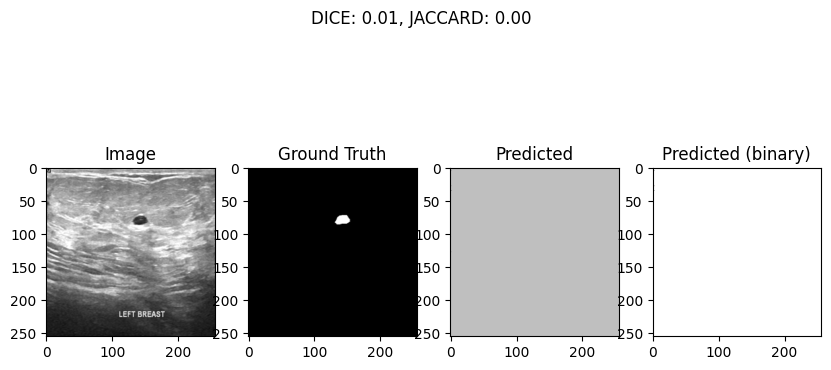

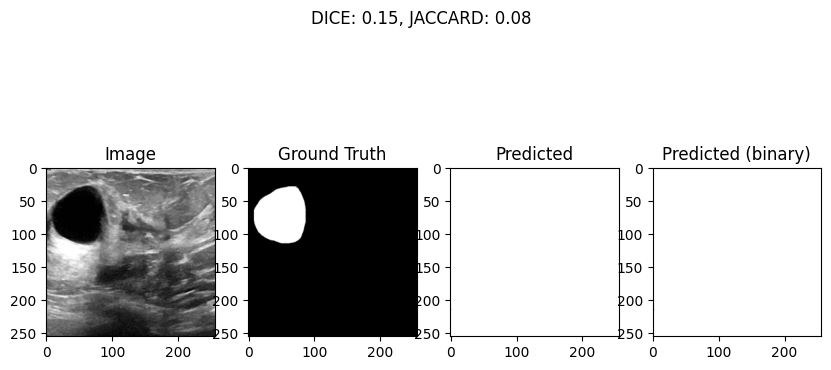

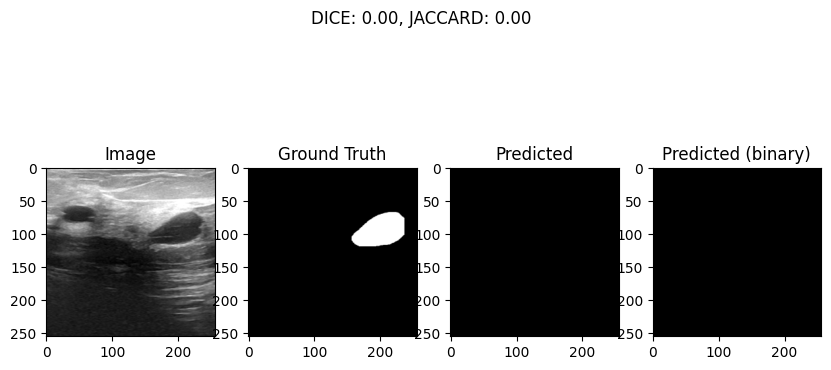

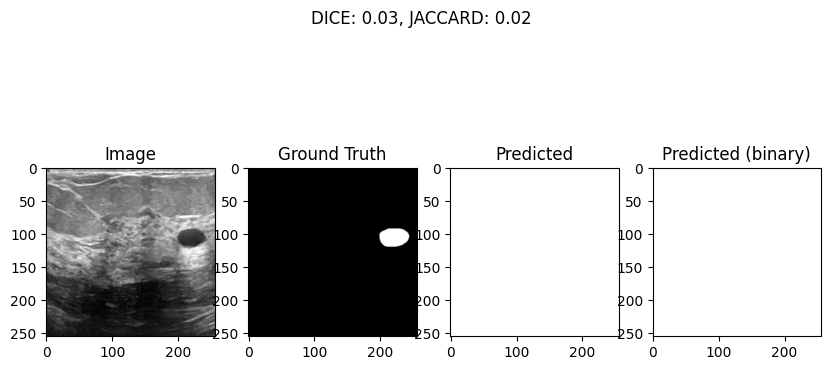

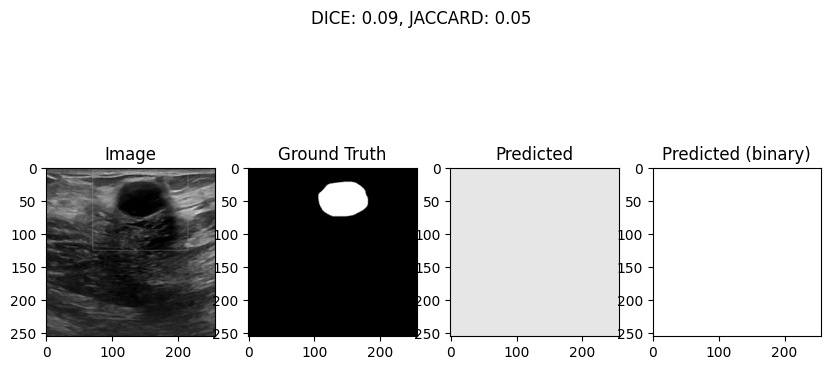

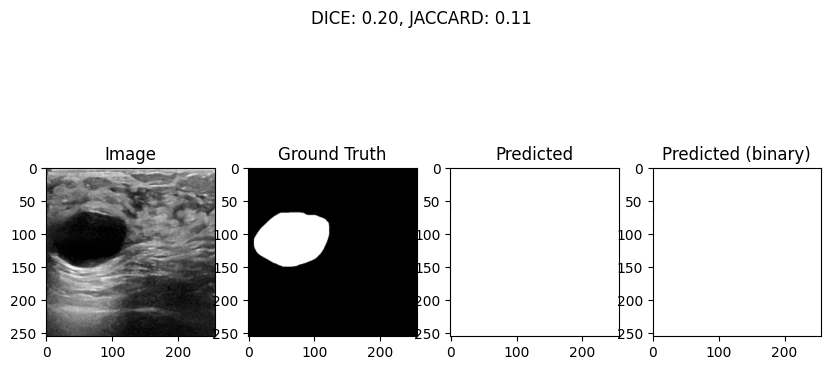

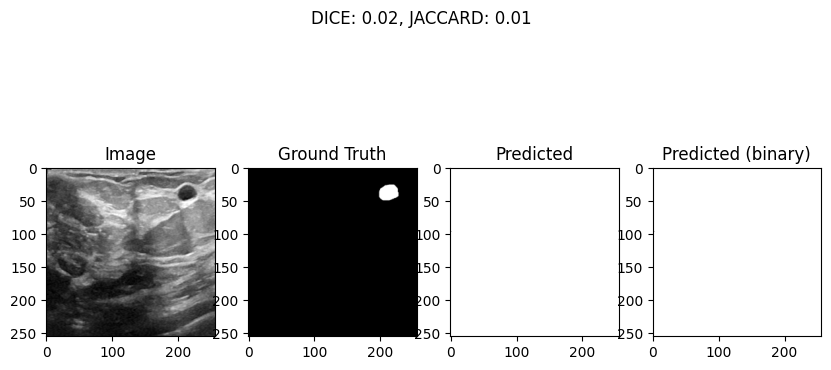

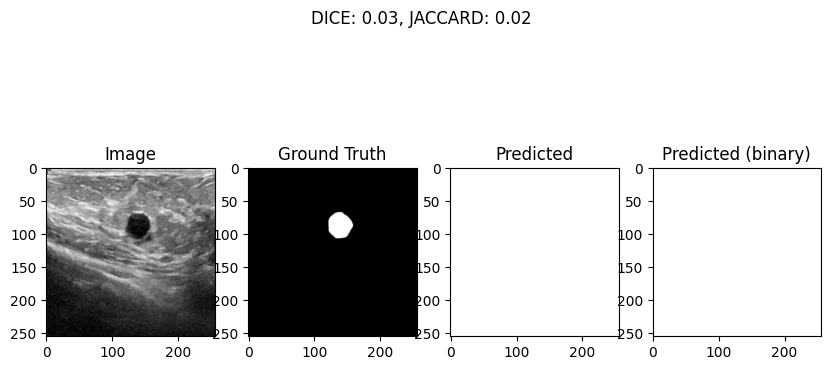

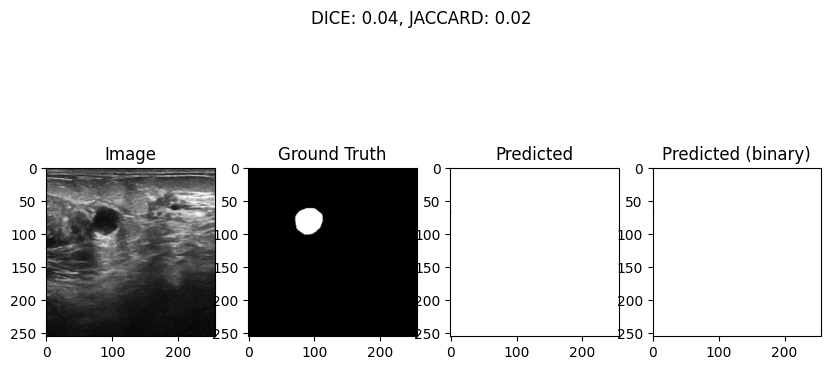

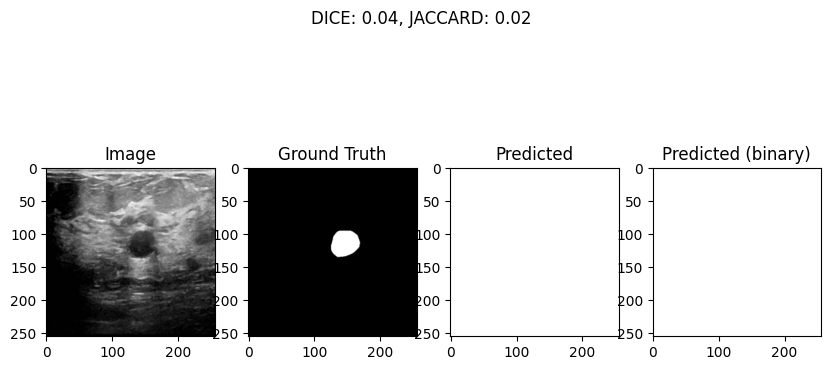

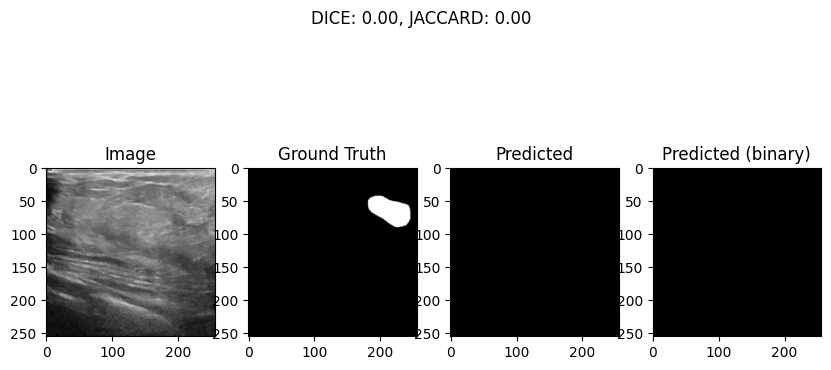

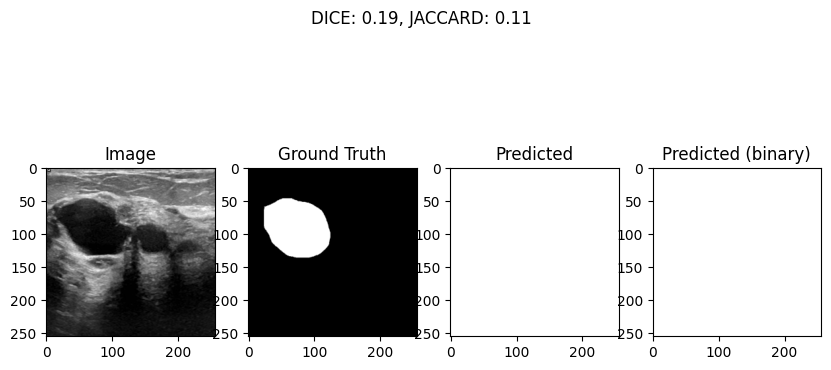

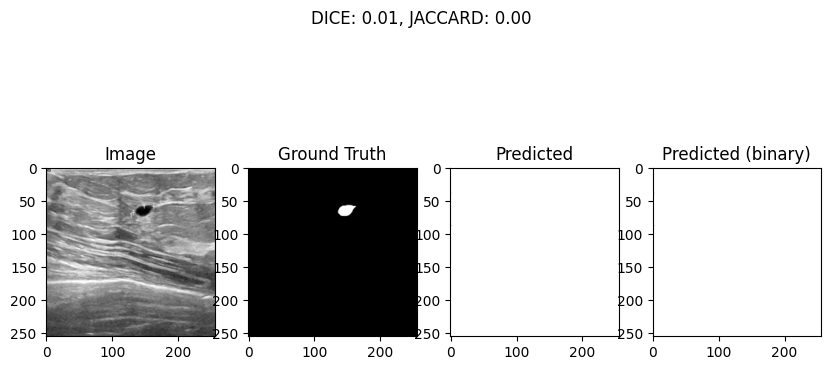

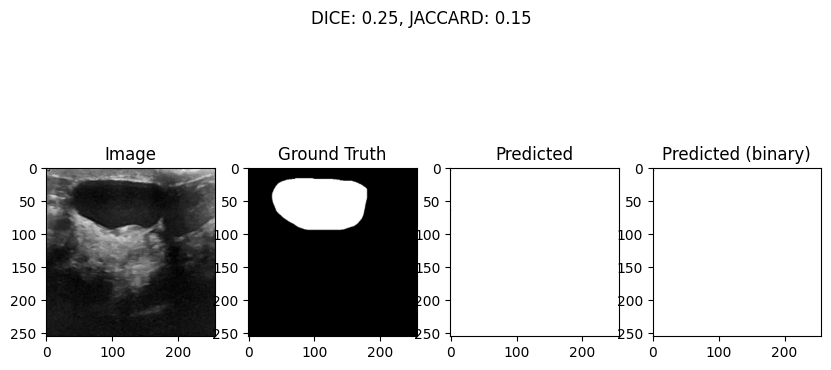

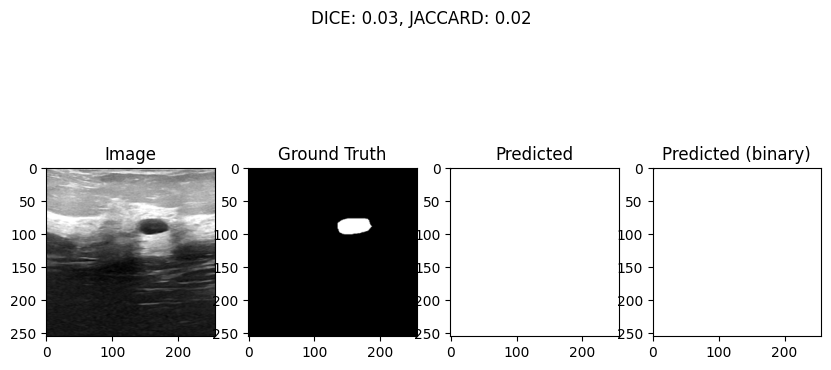

In [227]:
# load the best model weights
from skimage.segmentation import morphological_chan_vese
from numpy import squeeze
from skimage.draw import polygon
from skimage.filters import threshold_otsu
from skimage.segmentation import active_contour
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to evaluate the model
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, float]:
    """
    Evaluate the performance of a binary image segmentation model by calculating the DICE and JACCARD measures.

    Args:
    - y_true (numpy.ndarray): a binary numpy array representing the true segmentation mask.
    - y_pred (numpy.ndarray): a binary numpy array representing the predicted segmentation mask.

    Returns:
    - A tuple of floats representing the DICE and JACCARD measures respectively.
    """
    # flatten the true and predicted masks
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # calculate the DICE and JACCARD measures
    dice = (2.0 * np.sum(y_true * y_pred)) / (np.sum(y_true) + np.sum(y_pred))
    jaccard = np.sum(y_true * y_pred) / (np.sum(y_true) + np.sum(y_pred) - np.sum(y_true * y_pred))

    return dice, jaccard

# model.load_weights('binary_cross_entropy_and_accuracy_fcn_best_weights.h5')
model.load_weights('best_bce_dice_model.h5')

for tumor_type in os.listdir(data_dir):
    tumor_type_dir = os.path.join(data_dir, tumor_type)
    # Loop through each image file in the tumor type subdirectory
    for filename in os.listdir(tumor_type_dir):
        # Check if the file is an image file in PNG format
        if filename.endswith('.png'):
            # Check if the file is a mask image or not
            if ("mask" not in filename) & ("pred" not in filename):
                # Save image and mask directory (only first mask considered)
                img_path = os.path.join(tumor_type_dir, filename)
                mask_path = os.path.join(tumor_type_dir, filename.split(".png")[0] + "_mask.png")
                
                prediction_file_name = filename.split(".png")[0] + "_pred.png"
    
                test_img = Image.open(img_path).convert('L').resize((img_width, img_height))
                test_img = np.array(test_img) / 255.0
                test_img = np.expand_dims(test_img, axis=0)
                test_img = (np.repeat(test_img[..., np.newaxis], 3, axis=-1))
                initial_mask = model.predict(test_img)[0]
                
                # Convert to grayscale 1-channel
                test_img = test_img[:,:,:,0]
                initial_mask = initial_mask[:,:,0]

                ground_truth = Image.open(mask_path).convert('L').resize((img_width, img_height))
                ground_truth = np.array(ground_truth) / 255.0
                ground_truth = np.expand_dims(ground_truth, axis=0)

                # threshold the predicted mask
                thresh = threshold_otsu(initial_mask)
                initial_mask_binary = (initial_mask > thresh).astype(np.uint8)

                # apply active contours
#                 snake = active_contour(initial_mask, initial_mask_binary, alpha=0.1, beta=1.0, w_line=-1, w_edge=1, gamma=0.1, max_num_iter=2500, convergence=0.1)

#                 # create a mask using the contours
#                 rr, cc = np.round(snake[:, 0]).astype(int), np.round(snake[:, 1]).astype(int)
#                 initial_mask_binary = np.zeros_like(initial_mask_binary)
#                 initial_mask_binary[rr, cc] = 1

                # evaluate the model
                dice, jaccard = evaluate_model(ground_truth, initial_mask_binary)
                print("DICE score: ", dice)
                print("JACCARD score: ", jaccard)

                fig, axs = plt.subplots(1, 4, figsize=(10, 5))
                axs[0].imshow(test_img.reshape(256, 256), cmap='gray')
                axs[0].set_title('Image')
                axs[1].imshow(ground_truth.reshape(256, 256), cmap='gray')
                axs[1].set_title('Ground Truth')
                axs[2].imshow(initial_mask.reshape(256, 256), cmap='gray')
                axs[2].set_title('Predicted')
                axs[3].imshow(initial_mask_binary.reshape(256, 256), cmap='gray')
                axs[3].set_title('Predicted (binary)')

                # add the average DICE and JACCARD scores to the plot title
                fig.suptitle(f'DICE: {dice:.2f}, JACCARD: {jaccard:.2f}')

                # plot only the last subplot (predicted binary mask)
#                 plt.imshow(initial_mask.reshape(256, 256), cmap='gray')
#                 plt.title(f'DICE: {dice:.2f}, JACCARD: {jaccard:.2f}')

#                 # Save predicted binary mask
#                 mpimg.imsave(os.path.join(tumor_type_dir, prediction_file_name), initial_mask.reshape(256, 256), cmap='gray')

#                 # show the plot
#                 plt.show()

